In [21]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import kerastuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K
import seaborn as sns
from tensorflow.keras.optimizers import Adam


## Preprocessing

In [2]:
#  Import and read the charity_data.csv.
book_df = pd.read_csv("../Resources/panda_df/books_cleaned_sample.csv")
book_df.head()

,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,3.56,Paperback,288,2010,2,1,9,0,3.735,0,0,0,0,0,0,1,0,0,0
1,4.36,Hardcover,208,2011,37,2,23,1,4.195,1,0,0,1,0,0,0,0,0,0
2,3.60,ebook,352,2011,5,1,2142,1,3.960,1,0,1,1,1,0,0,0,1,1
3,3.77,other,185,1989,397,6,142,1,3.800,0,1,1,1,1,0,0,0,0,1
4,3.76,Paperback,136,2001,98,5,8360,0,3.845,0,0,0,1,1,0,0,0,1,0


In [3]:
# Determine the number of unique values in each column.
book_df.nunique()

average_rating                             303
format                                       4
num_pages                                 1044
publication_year                            96
ratings_count                             3140
text_reviews_count                         938
to_read_count                             7258
series_binary                                2
author_average_rating                     1471
children                                     2
comics, graphic                              2
fantasy, paranormal                          2
fiction                                      2
history, historical fiction, biography       2
mystery, thriller, crime                     2
non-fiction                                  2
poetry                                       2
romance                                      2
young-adult                                  2
dtype: int64

In [4]:
# Convert categorical data to numeric with `pd.get_dummies`
book_df = pd.get_dummies(book_df)

In [5]:
book_df.head()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic",...,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,format_Hardcover,format_Paperback,format_ebook,format_other
0,3.56,288,2010,2,1,9,0,3.735,0,0,...,0,0,1,0,0,0,0,1,0,0
1,4.36,208,2011,37,2,23,1,4.195,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3.60,352,2011,5,1,2142,1,3.960,1,0,...,1,0,0,0,1,1,0,0,1,0
3,3.77,185,1989,397,6,142,1,3.800,0,1,...,1,0,0,0,0,1,0,0,0,1
4,3.76,136,2001,98,5,8360,0,3.845,0,0,...,1,0,0,0,1,0,0,1,0,0


In [6]:
# Split our preprocessed data into our features and target arrays
features = book_df.drop(columns=["average_rating"])
target = book_df["average_rating"]
# Split the preprocessed data into a training and testing dataset
#  YOUR CODE GOES HERE
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [7]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Identify the best hyperparameters using keras tuner

In [8]:
# Define keras tuner function
def build_model(hp):
    model = Sequential()

    #Allow Kerastuner to decide which activation function to use in the hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'leaky_relu'])

    # Tune the number of units in the first Dense layer
    model.add(Dense(hp.Int('input_units', min_value=40, max_value=200, step=10), activation=activation, input_dim=21))

    # Tune the number of hidden layers and the number of units in each layer
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(Dense(units=1, activation='linear'))  
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='mean_squared_error',
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model,
                    objective='val_mean_squared_error',
                    max_epochs=20,
                    project_name='keras_tuner')

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./keras_tuner/tuner0.json


In [9]:
# View the best hyperparameters
best_hps.values

{'activation': 'sigmoid',
 'input_units': 70,
 'n_layers': 4,
 'dense_0_units': 224,
 'learning_rate': 0.00022513718272652676,
 'dense_1_units': 128,
 'dense_2_units': 224,
 'dense_3_units': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

## Compile, Train and Evaluate the Model

In [10]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=21))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0026870545264693364),
            loss='mean_squared_error',
            metrics=['mean_absolute_error', 'mean_squared_error',])

In [12]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/50
1387/1387 [==============================] - 5s 3ms/step - loss: 0.1080 - mean_absolute_error: 0.2025 - mean_squared_error: 0.1080 - val_loss: 0.1182 - val_mean_absolute_error: 0.2087 - val_mean_squared_error: 0.1182
Epoch 2/50
1387/1387 [==============================] - 5s 3ms/step - loss: 0.1072 - mean_absolute_error: 0.2007 - mean_squared_error: 0.1072 - val_loss: 0.1184 - val_mean_absolute_error: 0.2113 - val_mean_squared_error: 0.1184
Epoch 3/50
1387/1387 [==============================] - 5s 3ms/step - loss: 0.1072 - mean_absolute_error: 0.2010 - mean_squared_error: 0.1072 - val_loss: 0.1176 - val_mean_absolute_error: 0.2098 - val_mean_squared_error: 0.1176
Epoch 4/50
1387/1387 [==============================] - 5s 3ms/step - loss: 0.1072 - mean_absolute_error: 0.2010 - mean_squared_error: 0.1072 - val_loss: 0.1215 - val_mean_absolute_error: 0.2155 - val_mean_squared_error: 0.1215
Epoch 5/50
1387/1387 [==============================] - 5s 3ms/step - loss: 0.1072 - mea

In [13]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

463/463 [==============================] - 0s 428us/step


,Actual,Predicted
44229,3.83,3.386457
48608,3.71,3.822008
55242,4.00,3.808436
11494,3.38,3.822165
1422,4.13,4.201386
2270,4.27,4.015524
48326,4.15,3.911199
41554,3.95,4.028079
14659,3.25,3.386457
27342,4.04,3.640514


In [14]:
ratings.describe()

,Actual,Predicted
count,14785.000000,14785.000000
mean,3.849767,3.872530
std,0.480780,0.359390
min,0.000000,0.673655
25%,3.620000,3.674447
50%,3.890000,3.884859
75%,4.120000,4.068743
max,5.000000,5.117587


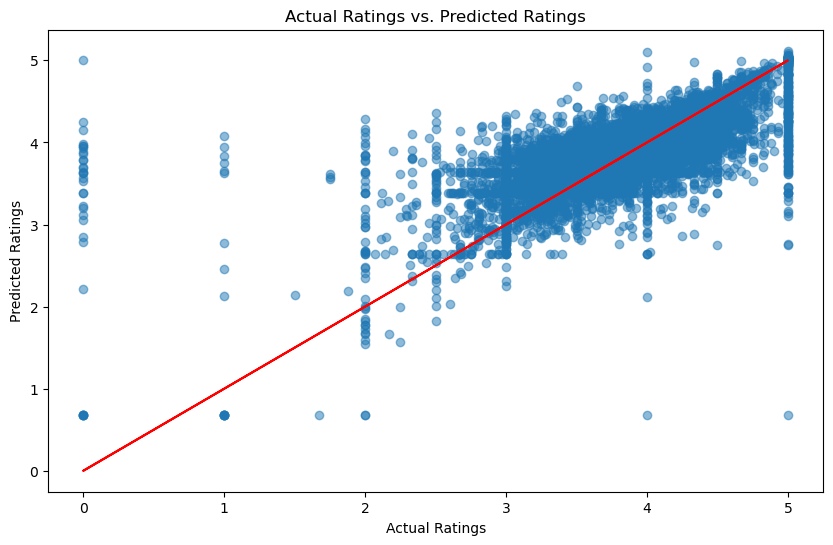

In [15]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()


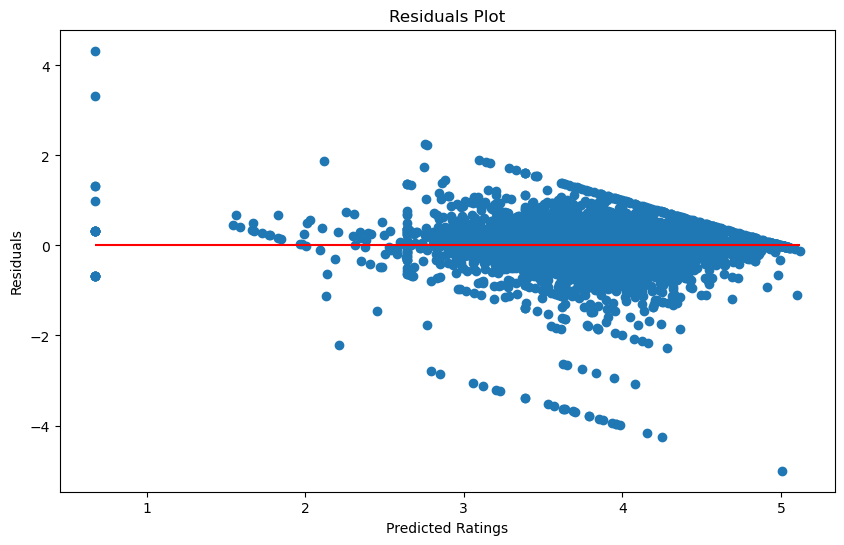

In [16]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [22]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])

# Calculate the R-squared score
r2 = r2_score(ratings["Actual"], ratings["Predicted"])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')


MAE: 0.210594509697541
MSE: 0.11964154677295902
R2: 0.4823713901609398


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_79474/905977283.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_79474/905977283.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


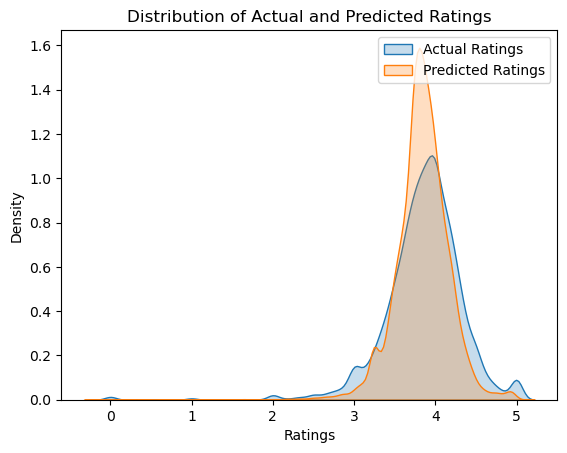

In [ ]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend()
plt.show()


## Creating a Custom loss function to penalize the model for predicting values outside the range of 0 and 5

In [23]:
# Create a custom loss function
def custom_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_pred - y_true), axis=-1)

    penalty_lower = K.mean(K.square(K.cast(y_pred < 0, 'float32') * y_pred), axis=-1)
    penalty_upper = K.mean(K.square(K.cast(y_pred > 5, 'float32') * (y_pred - 5)), axis=-1)

    return mse_loss + penalty_lower + penalty_upper


In [24]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=21))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0026870545264693364),
            loss=custom_loss,
            metrics=['mean_absolute_error', 'mean_squared_error'])

In [25]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

Epoch 1/50
1387/1387 [==============================] - 2s 1ms/step - loss: 0.1569 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1568 - val_loss: 0.1213 - val_mean_absolute_error: 0.2184 - val_mean_squared_error: 0.1213
Epoch 2/50
1387/1387 [==============================] - 2s 1ms/step - loss: 0.1274 - mean_absolute_error: 0.2323 - mean_squared_error: 0.1274 - val_loss: 0.1971 - val_mean_absolute_error: 0.3281 - val_mean_squared_error: 0.1968
Epoch 3/50
1387/1387 [==============================] - 2s 1ms/step - loss: 0.1251 - mean_absolute_error: 0.2282 - mean_squared_error: 0.1251 - val_loss: 0.1204 - val_mean_absolute_error: 0.2149 - val_mean_squared_error: 0.1204
Epoch 4/50
1387/1387 [==============================] - 2s 1ms/step - loss: 0.1210 - mean_absolute_error: 0.2209 - mean_squared_error: 0.1210 - val_loss: 0.1237 - val_mean_absolute_error: 0.2157 - val_mean_squared_error: 0.1237
Epoch 5/50
1387/1387 [==============================] - 1s 1ms/step - loss: 0.1205 - mea

In [26]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

463/463 [==============================] - 0s 353us/step


,Actual,Predicted
44229,3.83,3.372582
48608,3.71,3.678637
55242,4.00,3.590714
11494,3.38,3.705079
1422,4.13,3.943347
2270,4.27,3.805143
48326,4.15,3.706934
41554,3.95,3.863194
14659,3.25,3.320033
27342,4.04,3.544397


In [27]:
ratings.describe()

,Actual,Predicted
count,14785.000000,14785.000000
mean,3.849767,3.697946
std,0.480780,0.312857
min,0.000000,0.644584
25%,3.620000,3.544322
50%,3.890000,3.699533
75%,4.120000,3.867742
max,5.000000,4.756008


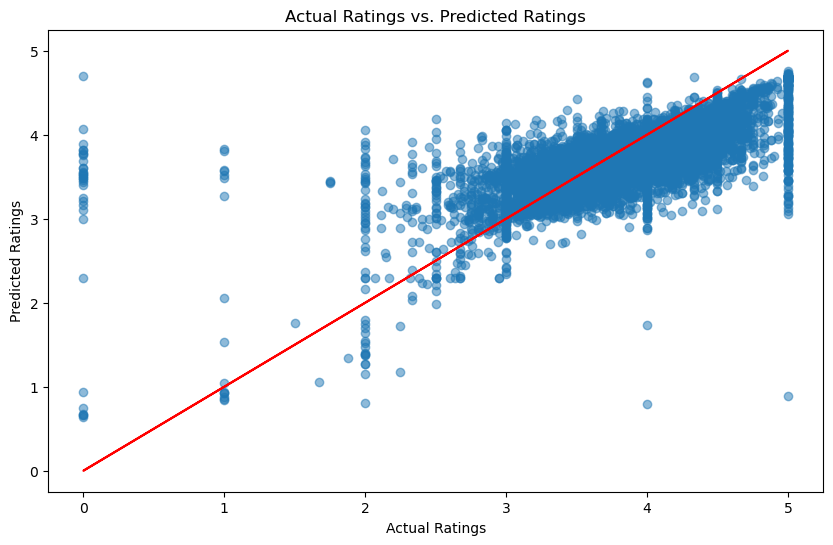

In [28]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()

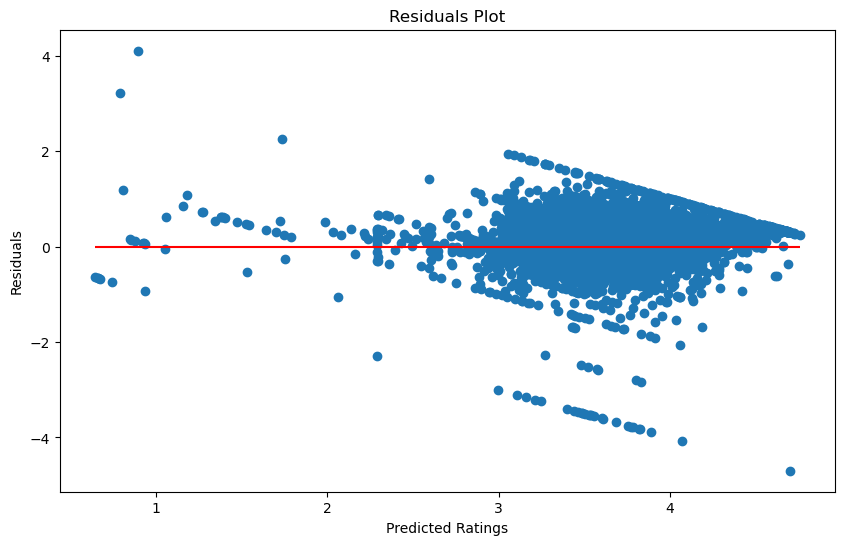

In [29]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [30]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])

# Calculate the r-squared value
r2 = r2_score(ratings["Actual"], ratings["Predicted"])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

MAE: 0.2660078088697808
MSE: 0.1408351825706816
R2: 0.39067722094204105


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_79474/1445386904.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_79474/1445386904.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


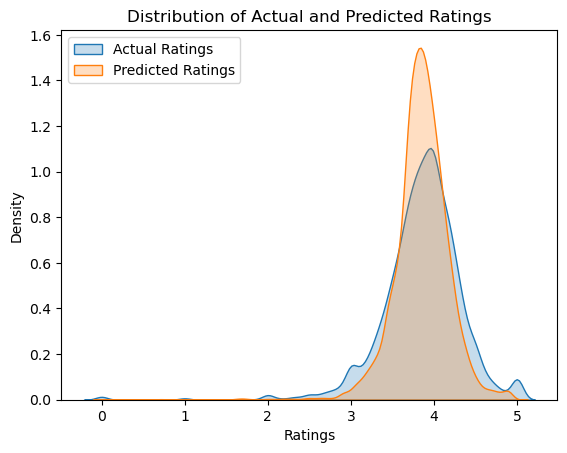

In [ ]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.show()

## Modify the loss function to give more weight for under represented ratings below 2

In [ ]:
# Define custom loss function
def weighted_loss(y_true, y_pred):
    # Basic Mean Squared Error
    mse_loss = K.mean(K.square(y_pred - y_true), axis=-1)

    # Penalties for predictions outside the range 0-5
    penalty_lower = K.mean(K.square(K.cast(y_pred < 0, 'float32') * y_pred), axis=-1)
    penalty_upper = K.mean(K.square(K.cast(y_pred > 5, 'float32') * (y_pred - 5)), axis=-1)

    # Define a threshold below which the data is considered underrepresented
    underrepresented_threshold = 2

    # Calculate weights based on the threshold
    weights = K.cast(y_true < underrepresented_threshold, 'float32') + 1

    # Apply the weights to the mse_loss
    weighted_mse_loss = weights * mse_loss

    return K.mean(weighted_mse_loss) + penalty_lower + penalty_upper

In [ ]:
# Define the best hyperparameters using the hyperband tuner and the custom loss function
def build_model(hp):
    model = Sequential()

    #Allow Kerastuner to decide which activation function to use in the hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'leaky_relu'])

    # Tune the number of units in the first Dense layer
    model.add(Dense(hp.Int('input_units', min_value=40, max_value=200, step=10), activation=activation, input_dim=21))

    # Tune the number of hidden layers and the number of units in each layer
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(Dense(units=1, activation='linear'))  
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss=weighted_loss,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model,
                    objective='val_mean_squared_error',
                    max_epochs=20,
                    project_name='keras_tuner_weighted_loss')

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 26 Complete [00h 00m 15s]
val_mean_squared_error: 0.11692462861537933

Best val_mean_squared_error So Far: 0.11656531691551208
Total elapsed time: 00h 04m 04s


In [ ]:
# View the best hyperparameters
best_hps.values

{'activation': 'sigmoid',
 'input_units': 80,
 'n_layers': 2,
 'dense_0_units': 256,
 'learning_rate': 0.004299467834113254,
 'dense_1_units': 96,
 'dense_2_units': 64,
 'dense_3_units': 128,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0018'}

In [ ]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=21))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.004299467834113254),
            loss=weighted_loss,
            metrics=['mean_absolute_error', 'mean_squared_error'])

In [ ]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=1, validation_data=(X_test_scaled, y_test))

Epoch 1/50
44353/44353 [==============================] - 20s 452us/step - loss: 0.1766 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1488 - val_loss: 0.1790 - val_mean_absolute_error: 0.2620 - val_mean_squared_error: 0.1478
Epoch 2/50
44353/44353 [==============================] - 20s 450us/step - loss: 0.1549 - mean_absolute_error: 0.2291 - mean_squared_error: 0.1268 - val_loss: 0.1526 - val_mean_absolute_error: 0.2173 - val_mean_squared_error: 0.1215
Epoch 3/50
44353/44353 [==============================] - 20s 447us/step - loss: 0.1530 - mean_absolute_error: 0.2267 - mean_squared_error: 0.1250 - val_loss: 0.2042 - val_mean_absolute_error: 0.3009 - val_mean_squared_error: 0.1795
Epoch 4/50
44353/44353 [==============================] - 20s 447us/step - loss: 0.1514 - mean_absolute_error: 0.2242 - mean_squared_error: 0.1235 - val_loss: 0.1532 - val_mean_absolute_error: 0.2149 - val_mean_squared_error: 0.1236
Epoch 5/50
44353/44353 [==============================] - 20s 449us/

In [ ]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

463/463 [==============================] - 0s 264us/step


,Actual,Predicted
44229,3.83,3.439334
48608,3.71,3.850633
55242,4.00,3.745118
11494,3.38,3.902770
1422,4.13,4.185956
2270,4.27,4.142079
48326,4.15,3.838457
41554,3.95,4.046394
14659,3.25,3.353081
27342,4.04,3.756339


In [ ]:
ratings.describe()

,Actual,Predicted
count,14785.000000,14785.000000
mean,3.849767,3.849410
std,0.480780,0.370860
min,0.000000,-0.251416
25%,3.620000,3.676278
50%,3.890000,3.867038
75%,4.120000,4.059817
max,5.000000,4.523548


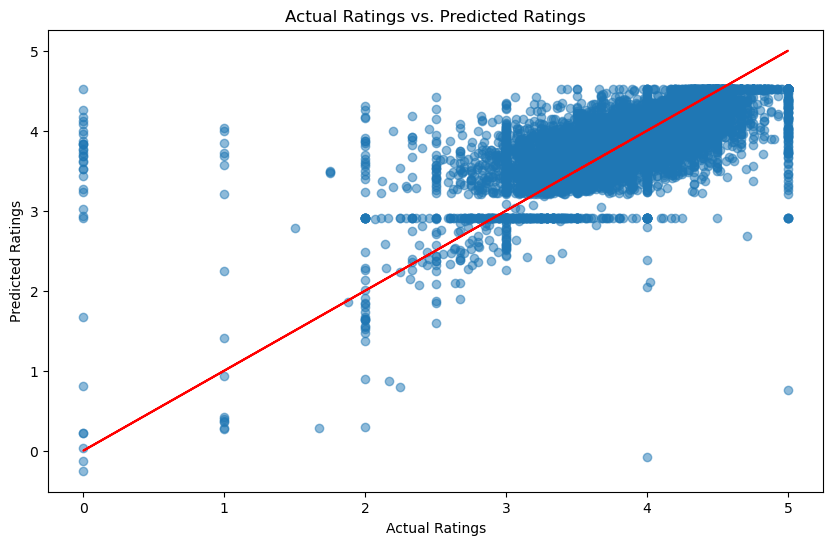

In [ ]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()

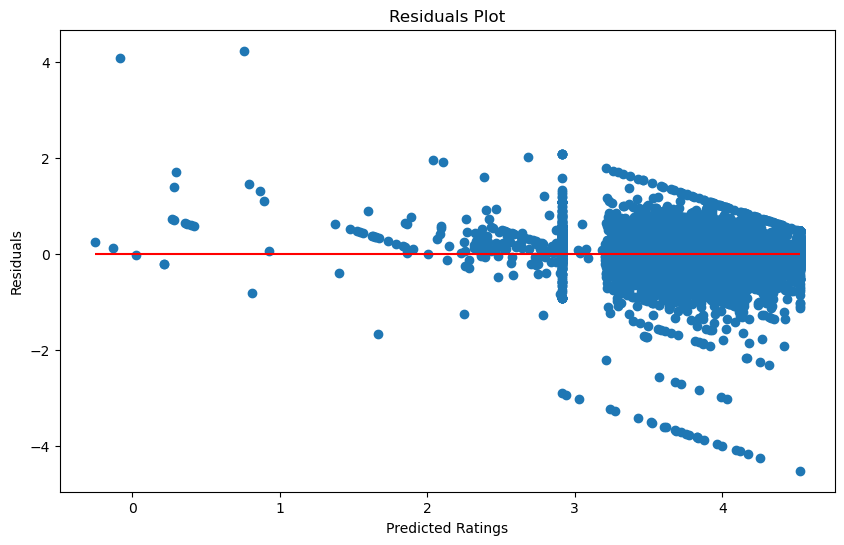

In [ ]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [ ]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])

print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 0.21799541656318694
MSE: 0.12430447182017973


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_85192/1445386904.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_85192/1445386904.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


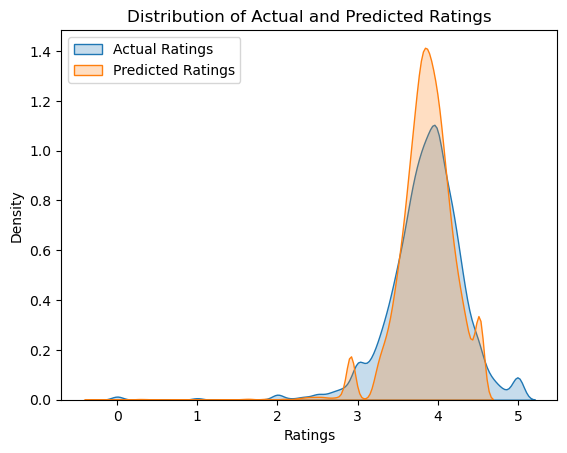

In [ ]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.show()

In [31]:
book_df.head()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic",...,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,format_Hardcover,format_Paperback,format_ebook,format_other
0,3.56,288,2010,2,1,9,0,3.735,0,0,...,0,0,1,0,0,0,0,1,0,0
1,4.36,208,2011,37,2,23,1,4.195,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3.60,352,2011,5,1,2142,1,3.960,1,0,...,1,0,0,0,1,1,0,0,1,0
3,3.77,185,1989,397,6,142,1,3.800,0,1,...,1,0,0,0,0,1,0,0,0,1
4,3.76,136,2001,98,5,8360,0,3.845,0,0,...,1,0,0,0,1,0,0,1,0,0


In [72]:
# Drop the average_rating values below 1
filtered_book_df = book_df[(book_df["average_rating"] >= 1) & (book_df["average_rating"] != 5)]
filtered_book_df.describe()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,to_read_count,series_binary,author_average_rating,children,"comics, graphic",...,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,format_Hardcover,format_Paperback,format_ebook,format_other
count,58040.000000,58040.000000,58040.000000,5.804000e+04,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,...,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000,58040.000000
mean,3.841016,266.017867,2007.504066,6.233883e+02,38.266558,3942.095762,0.305393,3.876694,0.143246,0.085941,...,0.333856,0.233908,0.286096,0.045486,0.252705,0.175414,0.246123,0.612698,0.080307,0.060872
std,0.426965,160.787007,9.139433,1.853750e+04,467.672060,28575.233527,0.460578,0.318122,0.350327,0.280279,...,0.471593,0.423318,0.451939,0.208369,0.434567,0.380324,0.430755,0.487138,0.271770,0.239097
min,1.000000,0.000000,1912.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.620000,160.000000,2004.000000,9.000000e+00,2.000000,19.000000,0.000000,3.720000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,256.000000,2010.000000,2.700000e+01,5.000000,111.000000,0.000000,3.895000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,4.110000,352.000000,2014.000000,9.600000e+01,14.000000,674.000000,1.000000,4.062625,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,4.970000,1498.000000,2020.000000,3.255518e+06,59827.000000,835383.000000,1.000000,5.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
# Split our preprocessed data into our features and target arrays
features = filtered_book_df.drop(columns=["average_rating"])
target = filtered_book_df["average_rating"]
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [74]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [90]:
# Define keras tuner function
def build_model(hp):
    model = Sequential()

    #Allow Kerastuner to decide which activation function to use in the hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'leaky_relu'])

    # Tune the number of units in the first Dense layer
    model.add(Dense(hp.Int('input_units', min_value=40, max_value=200, step=10), activation=activation, input_dim=21))

    # Tune the number of hidden layers and the number of units in each layer
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(Dense(units=1, activation='linear'))  
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='mean_squared_error',
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model,
                    objective='val_mean_squared_error',
                    max_epochs=20,
                    project_name='keras_tuner_filtered3')

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 28s]
val_mean_squared_error: 0.08454187214374542

Best val_mean_squared_error So Far: 0.08396345376968384
Total elapsed time: 00h 03m 55s


In [91]:
# View the best hyperparameters
best_hps.values

{'activation': 'sigmoid',
 'input_units': 180,
 'n_layers': 3,
 'dense_0_units': 224,
 'learning_rate': 0.00013978522409411077,
 'dense_1_units': 32,
 'dense_2_units': 128,
 'dense_3_units': 192,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [92]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=21))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001549106230919523),
            loss='mean_squared_error',
            metrics=['mean_absolute_error', 'mean_squared_error',])

In [93]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

Epoch 1/50
1361/1361 [==============================] - 2s 990us/step - loss: 0.1859 - mean_absolute_error: 0.2399 - mean_squared_error: 0.1859 - val_loss: 0.0907 - val_mean_absolute_error: 0.2142 - val_mean_squared_error: 0.0907
Epoch 2/50
1361/1361 [==============================] - 1s 797us/step - loss: 0.0895 - mean_absolute_error: 0.2079 - mean_squared_error: 0.0895 - val_loss: 0.0960 - val_mean_absolute_error: 0.2087 - val_mean_squared_error: 0.0960
Epoch 3/50
1361/1361 [==============================] - 1s 796us/step - loss: 0.0901 - mean_absolute_error: 0.2094 - mean_squared_error: 0.0901 - val_loss: 0.0864 - val_mean_absolute_error: 0.1977 - val_mean_squared_error: 0.0864
Epoch 4/50
1361/1361 [==============================] - 1s 802us/step - loss: 0.0891 - mean_absolute_error: 0.2068 - mean_squared_error: 0.0891 - val_loss: 0.0878 - val_mean_absolute_error: 0.2057 - val_mean_squared_error: 0.0878
Epoch 5/50
1361/1361 [==============================] - 1s 795us/step - loss: 0.

In [94]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

454/454 [==============================] - 0s 446us/step


,Actual,Predicted
50873,4.03,3.863961
392,3.85,4.164899
53022,3.58,3.869974
33043,3.92,3.946406
1884,3.69,3.896241
21818,3.91,3.701948
28617,3.92,3.808088
21335,3.87,3.912010
55195,3.44,3.575114
50413,3.88,3.815326


In [95]:
ratings.describe()

,Actual,Predicted
count,14510.000000,14510.000000
mean,3.834886,3.797757
std,0.434494,0.323938
min,1.000000,0.867550
25%,3.620000,3.644342
50%,3.880000,3.821912
75%,4.110000,3.997494
max,4.930000,4.775606


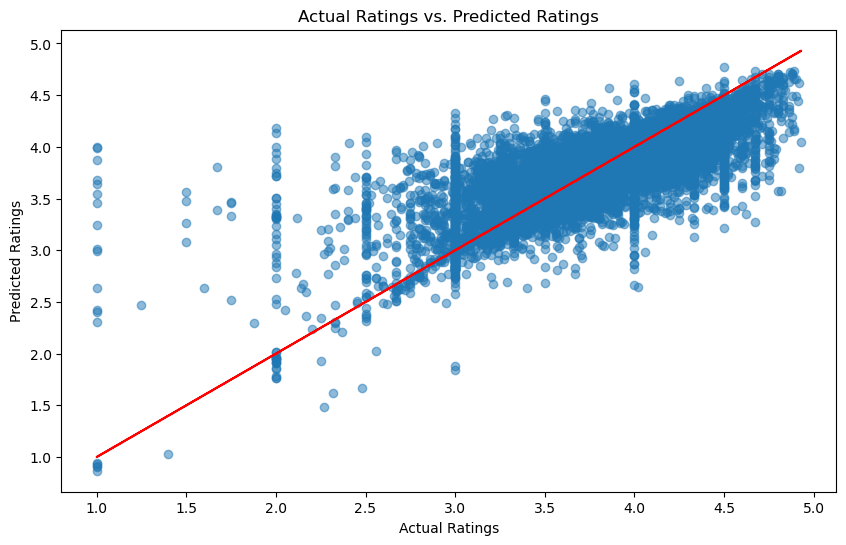

In [96]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()

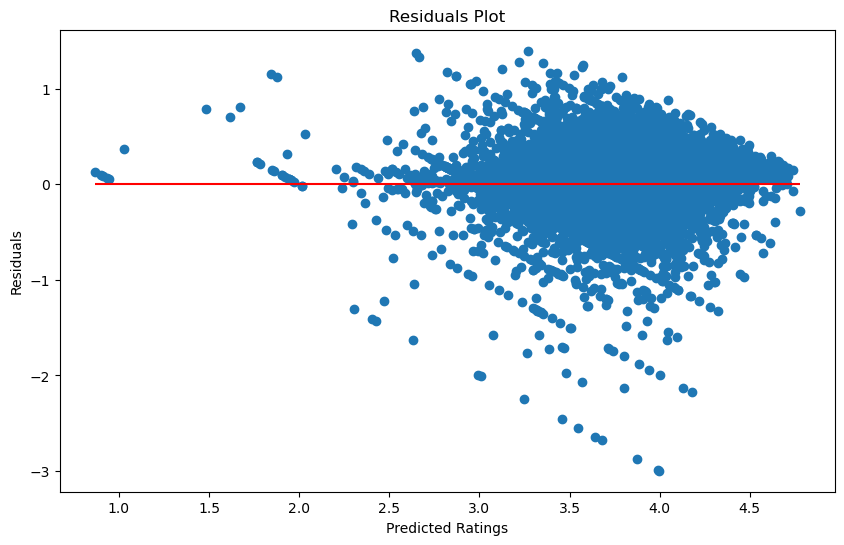

In [97]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [98]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])

# Calculate the R-squared score
r2 = r2_score(ratings["Actual"], ratings["Predicted"])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

MAE: 0.20024109719704958
MSE: 0.08503697737822483
R2: 0.5495254801411744


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_90842/3118130882.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_90842/3118130882.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


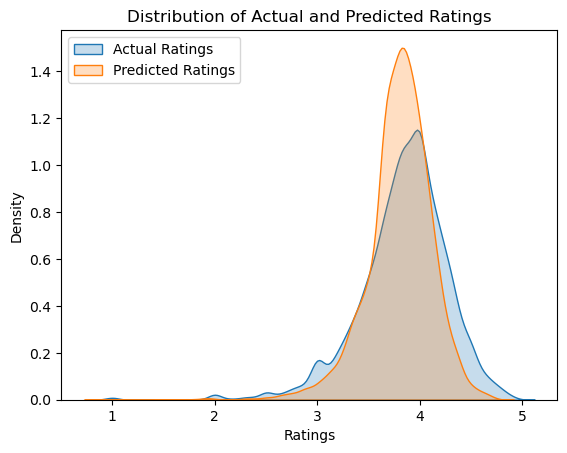

In [100]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.show()